In [27]:
import numpy as np
import pandas as pd
from numpy.random import seed, choice
from scipy import stats
from scipy.stats import (t, multivariate_t, 
                         norm, multivariate_normal, 
                         laplace)
from scipy.optimize import minimize
from scipy.fft import fft, ifft
from scipy.special import gamma, kv, beta
from scipy.integrate import quad_vec
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import matlab.engine
eng = matlab.engine.start_matlab("-r 'format long'")

TASK 1

Here is the task:  We wish to determine which is faster of the two methods, *for a fixed parameter estimation tolerance level, necessarily the same across both algorithms*.

(i) My t-iteration (titer.m) program, or
(ii) brute force MLE maximization using BFGS.

This is done with simulation and recording the time it takes for, say, k=100 or 1000 estimations. You report the two times as "Based on 100 (or 1000) replications, and a requested parameter estimation tolerance of (say) 4 significant digits, the total time required for each of the two algorithms are xxx seconds, and yyy seconds, respectively".

First for titer:
For a fixed sample size, say T=250 (about one year of daily stock return data), generate a simulated IID Student t data set, call it X. Run titer several times on this *same* data set X, varying the estimation tolerance, until you determine the value that leads to the outputted parameter vector having, say, 4 digit accuracy. Not at least 4, but (roughly) just 4.

You will need to go look in the titer.m codes and find everywhere a tolerance is required, e.g., in the root-finding function calls. An obvious suggestion is that you augment the function and pass parameter "tol" to it. Notice you could devise an algorithm to do this operation of determining the optimal value of tol. I guess the "round" command in Matlab will be of use. If you make a correct algorithm to do this, please show it and brag about it in your report. You can of course also do this step manually, but in real life, best you "algorithmatize" it.

Note: You do *not* compare the parameter estimate vector to the true parameter vector! But rather, start with tol=0.0000001, get the (pseudo-)MLE from titer, and keep increasing tol until the first four digits (in each of the 3 parameters) do not change.

Confirm with a few different X data sets until you are sure.

As an example, with tol set to an extreme value like 0.000001, you get, say for the df parameter,

df-hat-high-tol 5.125xxxxxx

and now you continue to increase tol until df-hat is 5.125, but the remaining digits differ from the value df-hat-high-tol. Notice every time, we use the same data set X. Ensure we get this 4-digit accuracy for all 3 parameters. Maybe one of the 3 parameters has a higher accuracy: that is okay, but all 3 need to have at least 4 digit accuracy, and ideally no more. We want the largest tol value possible to ensure this, so that we can do reliable speed comparisons with the other method.

No need to go overboard: The optimal value of tol should itself be accurate to about one significant digit, e.g., maybe you find tol=0.001, or 0.0005 to be right. That is enough. 

Again, check this with a few other X data sets. We need to ensure that the optimal tolerance value is robust to the data set used.

Now repeat the above, but for the BFGS-based algorithm for the exact MLE. Do not compare the MLE from BFGS to the estimated parameter vector from titer! Nor compare it to the true parameter vector. Both such comparisons are irrelevant for what we are trying to do.

So, now you have a tol value for titer, say tol_titer, and a tol for BFGS, say tol_BFGS, such that both deliver the estimated parameter vector to (about) 4 significant digits. Maybe these two tolerance values are close in value, but it does not matter.

Crucial, again, is to realize that the estimated parameter vector from titer, and that from BFGS, will differ, because the former is only pseudo-MLE. So, there is no need to compare the estimated parameter vectors across the two methods. We know they will not be exactly the same.

Next, fix a seed value, and confirm that, in a FOR loop over k, for 100 (or 1000) iterations, we generate 100 different IID Student t data sets, but such that, when we repeat this, *with the same seed value*, we get the same 100 data sets.

Now we know both algorithms (for this Student t model and parameter constellation you used, and target tolerance, here 4 significant digits) have the same accuracy. Thus, it now makes sense that we can compare their estimation times. So, you set up a FOR loop, at least k=100 iterations, in which you generate an IID Student t data set with T observations, and pass that data vector to *one* of the two estimation methods. You need to keep track of how long this takes, over the entire FOR loop. Then, you repeat this, *using the same seed value so you ensure that each of the 100 data sets are the same*, using the *other* estimation method; and likewise keep track of how long it takes.

NOTE: Realistically, you actually could use different seed values, because we are doing this for 100 (or 1000) data sets, as opposed to just one, but it is so easy to manage the seed value to ensure that you compare the two estimation methods with the same 100 data sets. Also, managing seed values in simulations is important in general, and hence why I want you to do this.

For keeping track of time, in Matlab, there are functions to do this. The oldest way in Matlab, still there, is "tic and toc" (oh, those dorky Matlab engineers...). Use the Matlab help command to investigate how this works, but crucially, it will then list the more sophisticated methods of starting a clock, and ending a clock, and reporting the elapsed time, also saving the result as a variable. I suggest you use Matlab's better methods for doing this, instead of the "manual", simple, tic-toc.

You of course show your codes (no need to show the titer.m codes; I have those, unless you modified them in some significant way), and discuss and demonstrate the above ideas for ensuring the two algorithms deliver about the same estimation tolerance. Then you report the estimation times. My hope is, titer is faster, but who knows.

Note: There is no efficiency gain for using the EM algorithm for MLE when working with the *univariate* Student t. That all changes with the multivariate Student t. So, no need to use it for the above comparison, as a "third method".


In [14]:
# Search for the TOL as such the accuracy of the pseudo-MLE estimation is within 4 digigs. 
seed(8002)
x = t.rvs(df=3, size=250)
tol0 = 1e-7 # Initial TOL
tol = tol0
params0 = np.array(eng.titer(x, 1, tol, nargout=3)) # Initial estimate with initial TOL
params = params0
diff = np.zeros((3,1))
while (diff < 1e-4).all():
    if max(diff) > 1e-6:
        tol_new = tol*1.2
    else:
        tol_new = tol*10
    # tol_new = tol*10
    params_new = np.array(eng.titer(x, 1, tol_new, nargout=3))
    diff = np.abs(params_new - params0)
    params_old = params
    params = params_new
    tol_old = tol
    tol = tol_new

resl_pmle = pd.DataFrame([params0, params_old, params_new], columns=['df_hat', 'mu_hat', 'c_hat'])
resl_pmle.insert(3, 'TOL', np.array([tol0, tol_old, tol_new]))


In [15]:
resl_pmle

,df_hat,mu_hat,c_hat,TOL
0,2.645344,-0.001312,1.008622,1.000000e-07
1,2.645283,-0.001314,1.008615,1.978136e-04
2,2.645073,-0.001315,1.008559,2.373763e-04


In [16]:
# Search for the TOL as such the accuracy of the MLE estimation is within 4 digigs. 
seed(8002)
x = t.rvs(df=3, size=250)
init = np.array([3.0, 0.00001, 1.0])
tol0 = 1e-7 # Initial TOL
tol = tol0
#options = eng.statset('TolX', tol, 'TolFun', tol)
params0 = np.array(eng.tlikmax0(x, init, tol0, nargout=1))
params0 = params0.reshape((params0.shape[1],))
# Initial estimate with initial TOL
params = params0
diff = np.zeros((3,1))
while (diff < 1e-4).all():
    if np.max(diff) > 1e-6:
        tol_new = tol*1.2
    else:
        tol_new = tol*10
    params_new = np.array(eng.tlikmax0(x, init, tol_new, nargout=1))
    params_new = params_new.reshape((params_new.shape[1],))

    diff = np.abs(params_new - params0)
    params_old = params
    params = params_new
    tol_old = tol
    tol = tol_new

resl_mle = pd.DataFrame([params0, params_old, params_new], columns=['mu_hat', 'c_hat', 'df_hat'])
resl_mle.insert(3, 'TOL', np.array([tol0, tol_old, tol_new]))


In [17]:
resl_mle

,mu_hat,c_hat,df_hat,TOL
0,2.645343,-0.001312,1.008622,1.000000e-07
1,2.645343,-0.001311,1.008621,2.488320e-04
2,2.645721,-0.001330,1.008651,2.985984e-04


In [2]:
# Search for the TOL as such the accuracy of the MLE estimation is within 4 digigs. 
np.random.seed(8002)
x = t.rvs(df=3, size=250)
tol0 = 1e-7 # Initial TOL
tol = tol0
options = eng.statset('TolX', tol, 'TolFun', tol)
params0 = np.array(eng.mle(x, 'Distribution', 'tLocationScale', 'Options', options, nargout=1))
params0 = params0.reshape((params0.shape[1],))
# Initial estimate with initial TOL
params = params0
diff = np.zeros((3,1))
while (diff < 1e-4).all():
    if np.max(diff) > 1e-6:
        tol_new = tol*2
    else:
        tol_new = tol*10
    # tol_new = tol*10
    options = eng.statset('TolX', tol_new, 'TolFun', tol_new)
    params_new = np.array(eng.mle(x, 'Distribution', 'tLocationScale', 'Options', options, nargout=1))
    params_new = params_new.reshape((params_new.shape[1],))

    diff = np.abs(params_new - params0)
    params_old = params
    params = params_new
    tol_old = tol
    tol = tol_new

resl_mle = pd.DataFrame([params0, params_old, params_new], columns=['mu_hat', 'c_hat', 'df_hat'])
resl_mle.insert(3, 'TOL', np.array([tol0, tol_old, tol_new]))

In [3]:
resl_mle

,mu_hat,c_hat,df_hat,TOL
0,-0.001312,1.008622,2.645344,1.000000e-07
1,-0.001316,1.008609,2.645330,1.600000e-04
2,-0.001312,1.008638,2.645478,3.200000e-04


In [13]:
# Compare the runtimes between titer and tlikmax0
import time
seed(8000)
n = 1000
tol_titer = 2e-4
tol_mle = 2e-4
x = t.rvs(df=3, loc=1, scale=2, size=250*n)
x = x.reshape((250, n))
init = np.array([4, 2.0, 2.0])
params_titer = np.zeros((3,n))
params_mle = np.zeros((3,n))

start = time.time()
for k in range(n):
    params_titer[:, k] = np.array(eng.titer(np.array(x[:,k]), 1, tol_titer, nargout=3))
end = time.time()
exect_titer = end - start
print("Execution time of titer: {}".format(exect_titer))

start = time.time()
for k in range(n):
    temp = np.array(eng.tlikmax0(np.array(x[:,k]), init, tol_mle, nargout=1))
    params_mle[:, k] = temp.reshape((temp.shape[1],))
end = time.time()
exect_mle = end - start
print("Execution time of mle: {}".format(exect_mle))

Execution time of titer: 9.316118001937866
Execution time of mle: 5.5966246128082275


In [20]:
# # Compare the runtimes between titer and mle

import time
seed(8000)
n = 1000
tol_titer = 2e-4
tol_mle = 3e-4
x = t.rvs(df=2, loc=1, scale=12, size=250*n)
x = x.reshape((250, n))
params_titer = np.zeros((3,n))
params_mle = np.zeros((3,n))

start = time.time()
for k in range(n):
    params_titer[:, k] = np.array(eng.titer(np.array(x[:,k]), 1, tol_titer, nargout=3))
end = time.time()
exect_titer = end - start
print("Execution time of titer: {}".format(exect_titer))

options = eng.statset('TolX', tol_mle, 'TolFun', tol_mle)
start = time.time()
for k in range(n):
    temp = np.array(eng.mle(np.array(x[:,k]), 'Distribution', 'tLocationScale', 'Options', options, nargout=1))
    params_mle[:, k] = temp.reshape((temp.shape[1],))
end = time.time()
exect_mle = end - start
print("Execution time of mle: {}".format(exect_mle))

Execution time of titer: 9.720207691192627
Execution time of mle: 10.409605503082275


Part II: The conditional distribution of a bivariate Student t.

Motivation:
This is a useful conceptual idea for dealing with a measure-zero event, and I used it to confirm the theoretical distributional results from a multivariate conditional saddlepoint approximation for AR(p) model selection. No need to look, but if you are curious, see my time series book, pp 382-3.

Preparation:
From my time series book, read section C.1. You can just skim up to equation C.14, and read and understand from C.14 to C.27.

Next, skim-read the attached short article, from author Ding on the *conditional* distribution of X2 given X1, where X1 and X2 are some margins of a multivariate t distribution. Note how recent the article is! You think such results would be known since 90 years.

We will be working in this assignment with just the bivariate version, so X1 and X2 will be scalars, not vectors. You do not need to understand the derivation, but notice the final result is very clear, and you can easily program and compute this, given the density parameter values.

We want to verify the author's result is correct (it is), because, as Ding points out, there were some previous errors in the literature on this, as well as more complicated derivations. Ding's method of proof is clean, smart, and correct.

Assignment:

II.1. From that paper, make a program that simply inputs the parameters of a bivariate Student t (2 location terms, and a 2X2 dispersion matrix, and the df parameter), and computes the parameters of the conditional distribution of X2 given X1.

II.2. From my time series book section that I mentioned above, make a program to simulate a bivariate Student t. You pass to your function the true parameters: 2 location terms, a 2 X 2 dispersion matrix, and the single df value, and of course, the number of bivariate vectors to simulate, say n. You can use location = [0, 0] and start with identity matrix dispersion, and play around with using df=1, 2, 3, 4. You can make a bivariate plot of the data, in Matlab; see functions like mesh, and related functions. Once you get all the coding done and make the nice plots, then, for the next questions, use a non-identity dispersion matrix, i.e., such that X1 and X2 are correlated.

Note: In the multivariate Student t, even with identity dispersion matrix, the univariate margin distributions are *not* independent. Can you say why? I can think of two explanations. You try.

II.3. Make a function that inputs the n X 2 matrix of simulated bivariate Student t values, as well as a parameter, a scalar, called x2. Choose a value where there is significant "mass" of the density, e.g., 0 is the best if E[X2]=0.

What you will do is "condition on x2". Clearly, the event X2 = x2 is measure zero, so that will not work in a simulation exercise. Instead, you extract from the n X 2 matrix those values of x1 that correspond to values of X2 that lie in the interval (x2-eps, x2+eps), for some small value eps>0. Call this subset of values X1midX2.

Notice that, as eps gets smaller, you will need a larger value of n to ensure that you get some elements out of it. Choose eps and n to enhance accuracy, meaning, very large n, and small eps, so that you get, say, at least 100, better 1000, values of x1 conditional on X2 being in the specified interval. Notice simulating the bivariate Student t is fast, so taking n to be, say, 1e6, is feasible.

II.4. The goal is to confirm that the paper is correct with its theoretical statement that the conditional is indeed Student t, but with different df value, as given in the paper. We do this by estimating the univariate IID Student t model on data set X1midX2. You can make a kernel density plot of the Student t conditional distribution based on the MLE from data set X1midX2, and overlay this with the theoretical Student t distribution from the paper. They should be very close, notably if you choose n large, and eps small. (For fun, you can use BFGS, and titer, and show both, along with, obviously, the theory result.)

Repeat this with other values of x2, say 4 values in total, e.g., 0, 1, 2, 3. Also, say, 3 different df values of the bivariate Student t model. I think the df value does not have to be larger than 1.0 (please check). If so, then you could thus try, say, df=1, df=3, df=5.

This could result in a single-page graphic in your report, containing the 3*4=12 sub-plots. You figure out how best to illustrate your results. But please not 12 pages, each with one graphic...


In [34]:
def tConditional(X1, mu1, mu2, Sigma: np.ndarray, v):
    '''
     This function returns the parameters of the conditional distribution of X2|X1, where (X1, X2) are bivariate location scale t distributed random variables, based on Ding (2016).   
    :param X1: value of X1, float
    :param mu1: location of X1, float
    :param mu2: location of X2, float
    :param Sigma: dispense matrix of X1 and X2, 2x2 ndarray
    :param v: degrees of freedom, same for the X1 and X2, float
    :return: 
        muout: location of the resulting conditional t distribution 
        cout: scale of the resulting conditional t distribution 
        vout: degree of freedom of the resulting conditional t distribution  
    '''
 
    d1 = (X1 - mu1)**2 / Sigma[0,0]
    muout = mu2 + Sigma[1,0] * (X1-mu1) / Sigma[0,0]
    fct = (v+d1)/(v+1)
    cout = fct * (Sigma[1,1] - Sigma[1,0]**2/Sigma[0,0])
    vout = v + 1
    return muout, cout, vout

In [25]:
np.sqrt(2)/2


0.7071067811865476

In [ ]:
def bivariate_t(mu, Sigma: numpy.ndarray, v, n):
    '''
    This function generates random vectors of bivariate location-scale t distribution.
    :param mu: Location of the distribution, 1-d array
    :param Sigma: dispense matrix of X1 and X2, 2x2 ndarray
    :param v: degrees of freedom, same for the X1 and X2, float
    :param n: number of generated vectors, float
    :return: 
        genearted data, 2xn ndarray
    '''
    from scipy.stats import multivariate_t
    simdata = multivariate_t.rvs(loc=mu, shape=Sigma, df=v, size=n)
    return simdata

dfs = [1, 2, 3, 4]
n = 200
# simdata = np.zeros((2,n))
seed(8050)
mu = [0, 1]  # locations of X1, X2
c = [1, 2]  # scale of X1, X2
rho = 0.6  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
         [rho*c[0]*c[1], c[1]**2]])
#fig, axs = plt.subplots(len(dfs), 1) 
for i in range(len(dfs)):
    bivt = multivariate_t(loc=mu, shape=Sigma, df=dfs[i])
    simdata = bivt.rvs(size=n)
    # mins = np.min(simdata, axis=0)
    # maxs = np.max(simdata, axis=0)
    # x = np.linspace(mins[0], maxs[0], 200)
    # y = np.linspace(mins[1], maxs[1], 200)
    # xv, yv = np.meshgrid(x, y)
    # pos = np.dstack((xv, yv))
    # axs[i].set_aspect("equal")
    # axs[i].contourf(x, y, bivt.pdf(pos))
    sns.kdeplot(x=simdata[:,0], y=simdata[:,1], cmap="Blues", fill=True)
    sns.scatterplot(x=simdata[:,0], y=simdata[:,1])
    #plt.show()

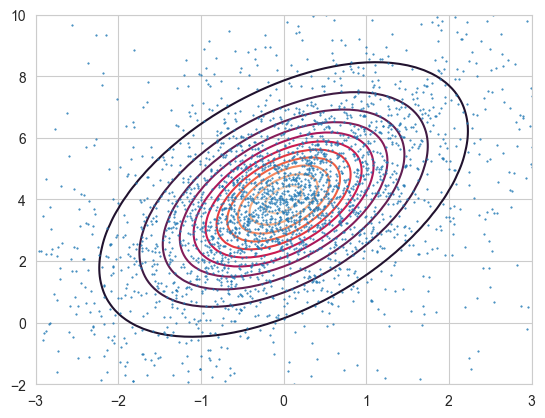

In [134]:
df = 3
n = 3000
# simdata = np.zeros((2,n))
# np.random.seed(8050)
mu = [0, 4]  # locations of X1, X2
c = [1, 2]  # scale of X1, X2
rho = 0.5  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
         [rho*c[0]*c[1], c[1]**2]])
bivt = multivariate_t(loc=mu, shape=Sigma, df=df)
simdata = bivt.rvs(size=n)
fig, ax = plt.subplots(1,1)

# mins = np.min(simdata, axis=0)
# maxs = np.max(simdata, axis=0)
# x = np.linspace([], maxs[0], 200)
# y = np.linspace(mins[1], maxs[1], 200)
x, y = np.mgrid[-3:3:0.1, -2:10:0.1]
pos = np.dstack((x, y))
#ax.set_aspect("equal")
ax.contour(x, y, bivt.pdf(pos), levels=12)
ax.plot(simdata[:,0], simdata[:,1], 'o', ms=.5)
ax.set(xlim=(-3,3), ylim=(-2,10))

plt.show()
# sns.kdeplot(x=simdata[:,0], y=simdata[:,1], cmap="Blues", fill=True)
# sns.scatterplot(x=simdata[:,0], y=simdata[:,1])

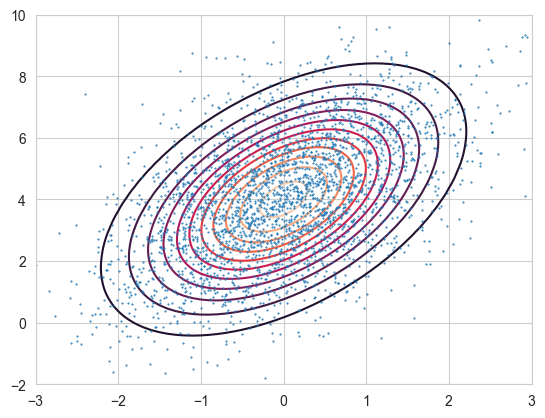

In [135]:
df = 3
n = 3000
# simdata = np.zeros((2,n))
# np.random.seed(8050)
mu = [0, 4]  # locations of X1, X2
c = [1, 2]  # scale of X1, X2
rho = 0.5  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
         [rho*c[0]*c[1], c[1]**2]])
bivn = multivariate_normal(mean=mu, cov=Sigma)
simdata = bivn.rvs(size=n)
fig, ax = plt.subplots(1,1)

# mins = np.min(simdata, axis=0)
# maxs = np.max(simdata, axis=0)
# x = np.linspace([], maxs[0], 200)
# y = np.linspace(mins[1], maxs[1], 200)
x, y = np.mgrid[-3:3:0.1, -2:10:0.1]
pos = np.dstack((x, y))
#ax.set_aspect("equal")
ax.contour(x, y, bivn.pdf(pos), levels=12)
ax.plot(simdata[:,0], simdata[:,1], 'o', ms=.5)
ax.set(xlim=(-3,3), ylim=(-2,10))

plt.show()
# sns.kdeplot(x=simdata[:,0], y=simdata[:,1], cmap="Blues", fill=True)
# sns.scatterplot(x=simdata[:,0], y=simdata[:,1])

In [26]:
n = int(1e+8)
df = 6
mu = np.array([1.0, 0.0])  # locations of X1, X2
c = np.array([1.0, 1.0])  # scale of X1, X2
rho = 0.2  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
                  [rho*c[0]*c[1], c[1]**2]])

In [27]:
bivt = multivariate_t(loc=mu, shape=Sigma, df=df)
simdata = bivt.rvs(size=n)

In [28]:
np.save("sim_bivt_df6_rho0p2.npy", simdata)

In [29]:
# P(X1 | x2-esp <= X2 <= x2+esp) by simulation
# simdata = np.load("sim_bivt.npy")

x2 = np.mean(simdata[:,1])
eps = 1.5e-5
X1 = simdata[:,0]
X1onx2 = X1[(simdata[:,1] > x2-eps) * (simdata[:,1] < x2+eps)]
condP = X1onx2.shape[0] / n
condP

1.132e-05

In [48]:
x1

-1.5867668239457074e-05

In [31]:
# init = np.array([mu[0], c[0], df])
params_1on2_mle = np.array(eng.mle(X1onx2, 'Distribution', 'tLocationScale', nargout=1))
params_1on2_mle

array([[1.02318447, 0.87560879, 5.61760883]])

In [32]:
params_1on2_titer = np.array(eng.titer(X1onx2, 1, nargout=3))
params_1on2_titer

array([5.61731894, 1.02318505, 0.87559479])

In [35]:
x1 = x2
mu_flip = np.flip(mu)  # locations of X1, X2
c_flip = np.flip(c)  # scale of X1, X2  
# correlation
Sigma_flip = np.array([[c[0]**2, rho*c[0]*c[1]],
         [rho*c[0]*c[1], c[1]**2]])

params_1on2_theory = tConditional(x1, mu_flip[0], mu_flip[1], Sigma_flip, df)
params_1on2_theory

(0.9999968264663521, 0.822857142891673, 7)

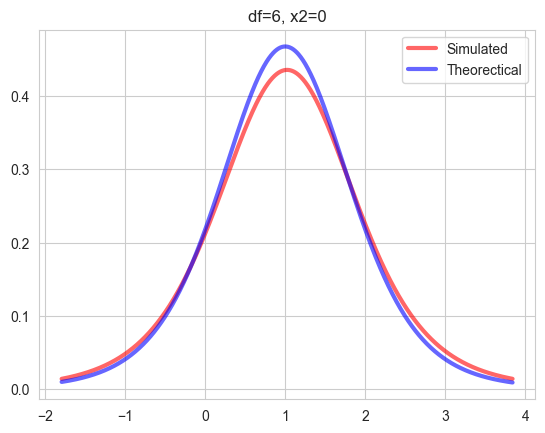

In [47]:
fig, ax = plt.subplots(1,1)
mu_sim, c_sim, df_sim = params_1on2_mle.flatten()
t_sim = t(loc=mu_sim, scale=c_sim, df=df_sim)
mu_th, c_th, df_th = params_1on2_theory
t_th = t(loc=mu_th, scale=c_th, df=df_th)

x = np.linspace(t_sim.ppf(0.01), t_sim.ppf(0.99), 1000)
ax.plot(x, t_sim.pdf(x), 'r-', lw=3, alpha=0.6, label='Simulated')
ax.plot(x, t_th.pdf(x), 'b-', lw=3, alpha=.6, label='Theorectical')
ax.set_title("df=6, x2=0")
ax.legend()

306
1.0


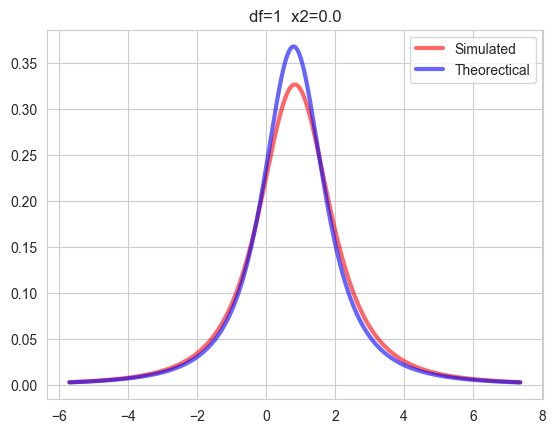

[0.8383461105664181, 1.095944524155416, 2.2643209119724457]
[0.8, 0.96, 2]
550
0.5800000000000001


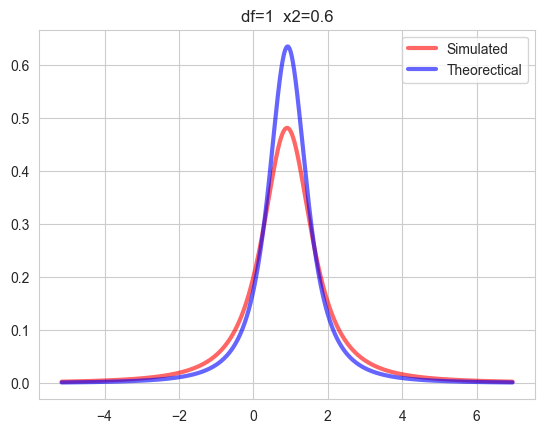

[0.9057694503849962, 0.7234237295275436, 1.765532798695048]
[0.9199999999999999, 0.5568000000000001, 2]
617
0.52


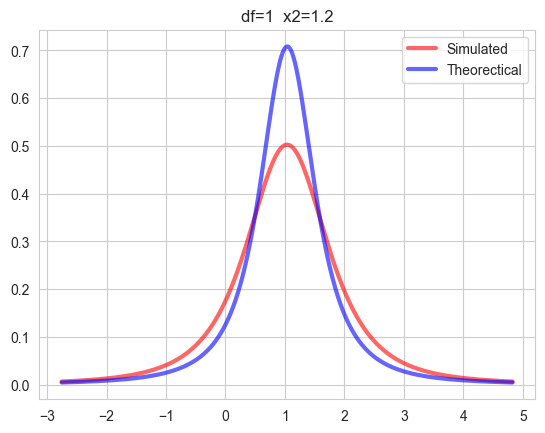

[1.0364794995501434, 0.7212784495079649, 2.5455419991388153]
[1.04, 0.4992, 2]
317
1.0


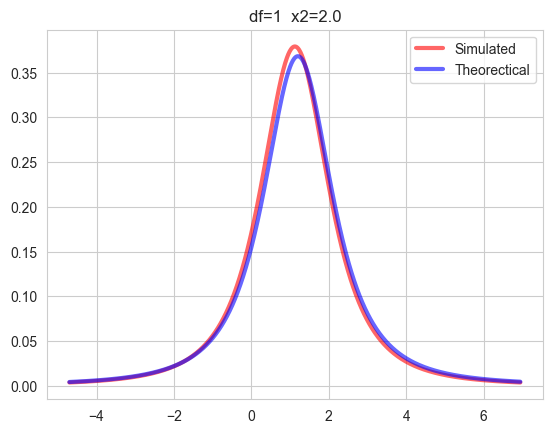

[1.1217874432999548, 0.9419617271749775, 2.1950048409663463]
[1.2, 0.96, 2]
419
1.0


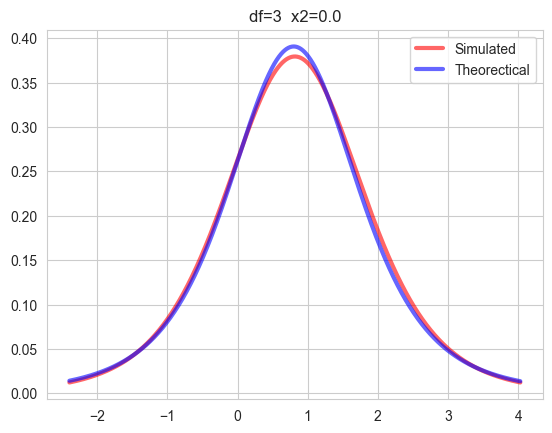

[0.8161272717182537, 1.0070319546365107, 5.739272187572865]
[0.8, 0.96, 4]
631
0.79


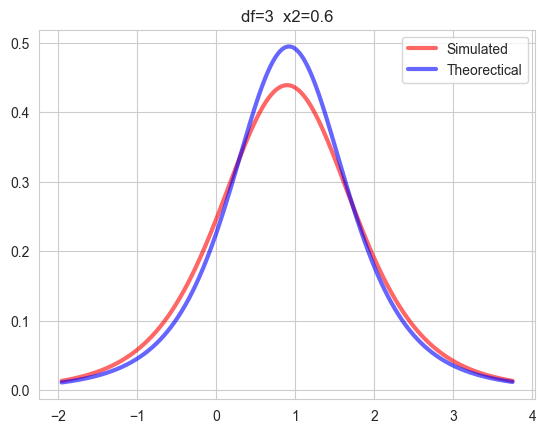

[0.8958707282331856, 0.8674656273092949, 5.288520292429372]
[0.9199999999999999, 0.7584, 4]
722
0.76


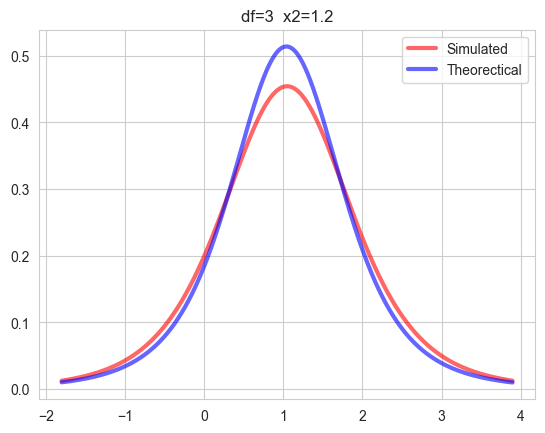

[1.0483014782075326, 0.8340783253573345, 4.833291138570836]
[1.04, 0.7296, 4]
415
1.0


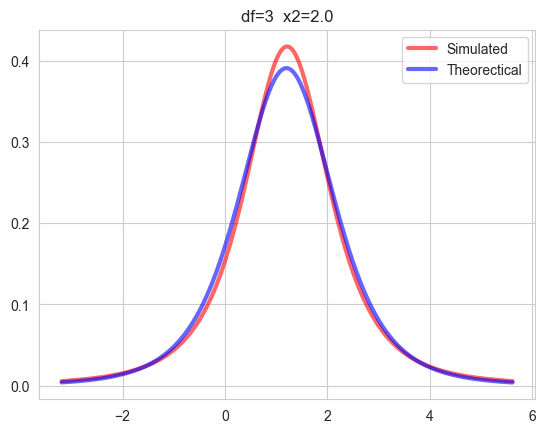

[1.2132678523563052, 0.8718054603871995, 2.652823898218669]
[1.2, 0.96, 4]
445
1.0


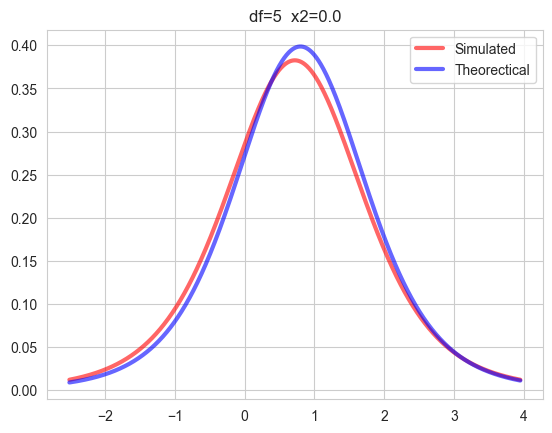

[0.7199490106311617, 0.9966119233234473, 5.506122659134828]
[0.8, 0.96, 6]
689
0.86


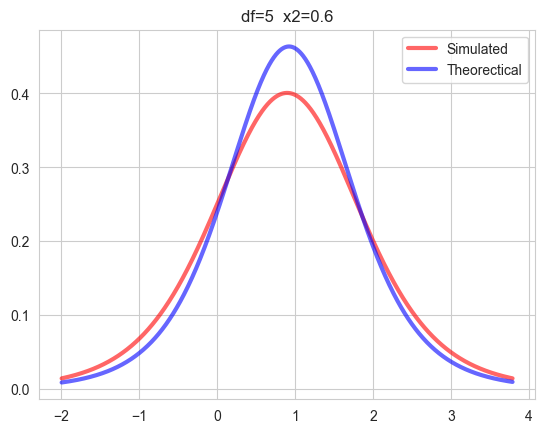

[0.8953968200696568, 0.9601053785715763, 6.883149057664098]
[0.9199999999999999, 0.8256, 6]
703
0.84


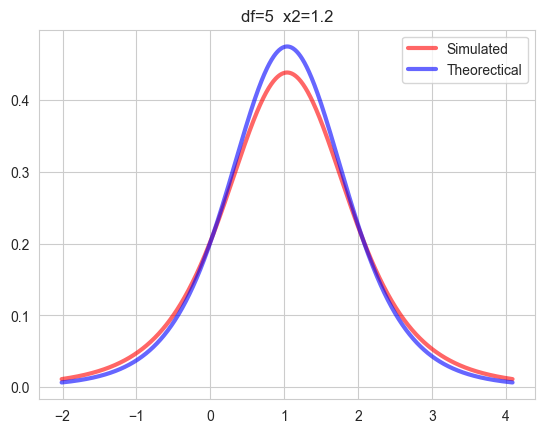

[1.0390733154044272, 0.8607838041160232, 4.453435456634928]
[1.04, 0.8063999999999999, 6]
434
1.0


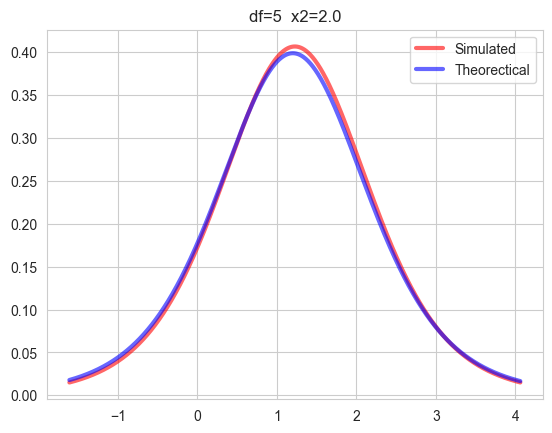

[1.2252883403759065, 0.9472766234477613, 7.034890209071078]
[1.2, 0.96, 6]


In [127]:
dfs = np.array([1, 3, 5])
x2s = np.array([0.0, 0.6, 1.2, 2.0])
#x2s = np.linspace(0.0, 2.0, 4)
n = int(2e+7)
eps = 5e-5 
mu = np.array([1.0, 1.0])  # locations of X1, X2
c = np.array([1.0, 1.0])  # scale of X1, X2
rho = 0.2  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
                  [rho*c[0]*c[1], c[1]**2]])

mus_th = np.flip(mu)  # locations of X1, X2
cs_th = np.flip(c)  # scale of X1, X2
Sigma_th = np.array([[cs_th[0]**2, rho*cs_th[0]*cs_th[1]], 
                    [rho*cs_th[0]*cs_th[1], cs_th[1]**2]])

for j in range(dfs.shape[0]):  # various df
    bivt = multivariate_t(loc=mu, shape=Sigma, df=dfs[j])
    simdata = bivt.rvs(size=n)
    
    for i in range(x2s.shape[0]):  # various x2
        x2 = x2s[i]
        X1 = simdata[:,0]
        X2 = simdata[:,1]
        X1onx2 = X1[(X2[:] > x2-eps) * (X2[:] < x2+eps)]
        print(X1onx2.shape[0])
        params_1on2_mle = np.array(eng.mle(X1onx2, 'Distribution', 'tLocationScale', nargout=1))
        mu_sim, c_sim, df_sim = params_1on2_mle.flatten()
        t_sim = t(loc=mu_sim, scale=c_sim, df=df_sim)
        
        x1 = x2
        mu_th, c_th, df_th = tConditional(x1, mus_th[0], mus_th[1], Sigma_th, dfs[j])
        t_th = t(loc=mu_th, scale=c_th, df=df_th)
        
        fig, ax = plt.subplots(1,1)
        x = np.linspace(t_sim.ppf(0.01), t_sim.ppf(0.99), 1000)
        ax.plot(x, t_sim.pdf(x), 'r-', lw=3, alpha=0.6, label='Simulated')
        ax.plot(x, t_th.pdf(x), 'b-', lw=3, alpha=0.6, label='Theorectical')
        ax.set_title("df=" + str(dfs[j]) + "  x2=" + str(x2))
        ax.legend()
        plt.show()
        print([mu_sim, c_sim, df_sim])
        print([mu_th, c_th, df_th])     
        


Part III: Estimating the bivariate Student t with MLE, and determining the distribution of a linear combination of the two jointly distributed random variables.

Motivation:
This has immediate usage for determining the distribution of a portfolio of financial assets. It is a starting point (or, as they say, is a "toy example"), because the multivariate Student t is in the elliptical class, meaning, the margins are symmetric, and the tail behavior of each asset (after accounting for the scale term) are the same: Remember, the multivariate Student t only has *one* shape parameter, the df. This model is also IID, which is not realistic for daily financial returns.

There is an amazing literature on estimating the parameters of the IID multivariate Student t, with numerous variations on the EM algorithm. See (just to get an idea; you will not implement it) https://core.ac.uk/download/pdf/82371806.pdf

Assignment:

III.1. Make a program to implement direct MLE for the bivariate case, noting there are only 2+3+1 = 6 parameters. That is, you have a function to return the log-likelihood of the bivariate IID Student t, and this gets passed to fminunc in Matlab (or fmincon if you wish to use it). HINT: I have it already, as Matlab code, in my time series book, page 527. So, this has become a "non-question" :-)

Note how we need to use constrained optimization, enforcing that the two scale terms in the dispersion matrix are positive, and the df is positive. You can just use my program, assuming it (still) works.

So, optional: Expand on mine and also ensure that the dispersion matrix is positive definite. This is harder, if you code it as a nonlinear constraint (using, say, eigenvalues), but in this case, with just one off-diagonal element, I think it should be very easy. You figure it out if you want, and perhaps use fmincon, which is a useful function to know about, e.g., in portfolio optimization when you cannot convert the problem to a quadratic programming problem and use quadprog.m, which is far faster.

Now simulate from a bivariate Student t (try a few different parameter constellations) and confirm the estimation algorithm works. Make nice, convincing, smart plots showing you get the correct parameters, such as a 6-element boxplot, with each of the 6 obviously corresponding to one of the 6 parameters. Be smart: For each of the 6 parameters, you boxplot the MLE estimates *minus the true parameter value*. This way, all 6 of the boxplots are nicely centered at zero. Remember, perfect labeling, font sizes, colors, everything. Go total Steve Jobs here.

III.2. Now imagine you have a set of bivariate financial asset returns data (e.g., daily percentage log or regular returns data on two stocks), and wish to fit the bivariate IID Student t model. For now, we will just use simulated bivariate Student t data. We want to know the distribution of a_1 X_1 + a_2 X_2, where a_1 and a_2 are, for us, between 0 and 1, and sum to one. This is the constraint for a long only, fully invested portfolio. So, as usual, you choose some set of parameters for the bivariate Student t, with a non-diagonal dispersion matrix, and then:

Simulate n replications, n large, and compute vector P = a_1 X_1 + a_2 X_2. Make a kernel density plot of this univariate object (the portfolio distribution), for some given weights a_1 and a_2 that you choose and fix.

Then use my equation C.27 to program the relevant characteristic function. Use the inversion theorem over a suitable grid of "x-values" to plot the density. Notice this is not the same as in your first take-home assignment: There, X_1 and X_2 were independent. As mentioned above, even with a diagonal dispersion matrix, X_1 and X_2 are not independent.

Overlay the true density from the inversion theorem, and the kernel density estimate from the simulation, and confirm they are very close. Make beautiful plots with appropriately thick lines, labeled x and y axes, a graphics legend, title, etc., with nice font sizes.


In [10]:
# Test MVTestimation by Marc
df = np.array([1, 3, 6, 9])
mu1 = np.array([1.0, 4.0])  # locations of X1
mu2 = np.array([2.0])  # locations of X2
temp = np.array(list(it.product(df, mu1, mu2)))

c1 = np.array([0.5, 1.0])  # scale of X1
c2 = np.array([1.5, 2.0])  # scale of X2
rho = np.linspace(0.2, 1.0, 4)  # correlation
S11 = np.repeat(c1**2, c2.shape[0]*rho.shape[0])
S22 = np.tile(np.repeat(c2**2, rho.shape[0]), c1.shape[0])
S12 = np.array([i*j*k for i in c1 for j in c2 for k in rho])
S = np.stack((S11, S12, S22), axis=1)

params_true = np.array([np.hstack((temp[i,:], S[j,:])) 
                        for i in range(temp.shape[0]) 
                        for j in range(S.shape[0])])
params_est = np.zeros(params_true.shape)

for i in range(params_true.shape[0]):
    df = params_true[i, 0]
    loc = params_true[i, 1:3]
    Sigma = np.array([[params_true[i, 3], params_true[i, 4]], 
                      [params_true[i, 4], params_true[i, 5]]])
    x = multivariate_t.rvs(loc=loc, shape=Sigma, df=df, size=1000)
    init = params_true[i,:] + 1e-3
    params_est[i, :] = np.array(eng.MVTestimation(x, init, nargout=1)).reshape((params_est[0].shape[0],))

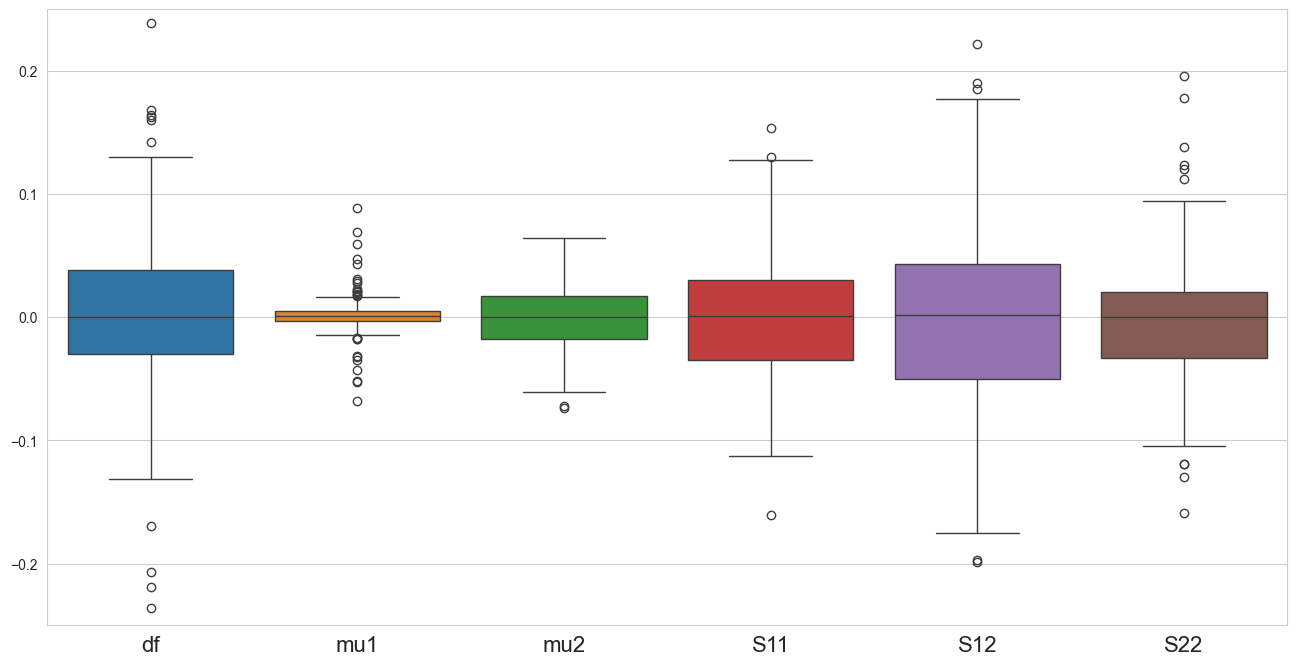

In [19]:
df = pd.DataFrame((params_est-params_true)/params_true, columns=['df', 'mu1', 'mu2', 'S11', 'S12', 'S22'])
# df1 = df.drop(58)
fig, ax = plt.subplots(1,1, figsize=(16, 8))
sns.boxplot(data=df)
ax.set(ylim=[-.25, .25])
ax.tick_params(axis='x', labelsize=16)

In [12]:
df

,df,mu1,mu2,S11,S12,S22
0,-0.035806,0.017722,-0.004853,-0.092933,0.004771,-0.059705
1,-0.029311,0.029130,0.026882,0.017349,0.005393,0.031868
2,0.054491,0.017177,0.010605,-0.071936,-0.106995,-0.086749
3,0.001000,0.001000,0.000500,0.004000,0.002219,0.000444
4,0.017921,0.027854,0.016975,-0.000583,0.221669,-0.057015
...,...,...,...,...,...,...
123,0.000111,0.000250,0.000500,0.001000,0.000722,0.000444
124,0.118434,0.002150,0.042957,-0.008224,-0.198792,0.058138
125,0.142319,-0.005041,-0.002410,0.066331,0.040797,0.007743
126,-0.206669,0.006900,-0.029404,-0.023599,-0.018803,-0.016939


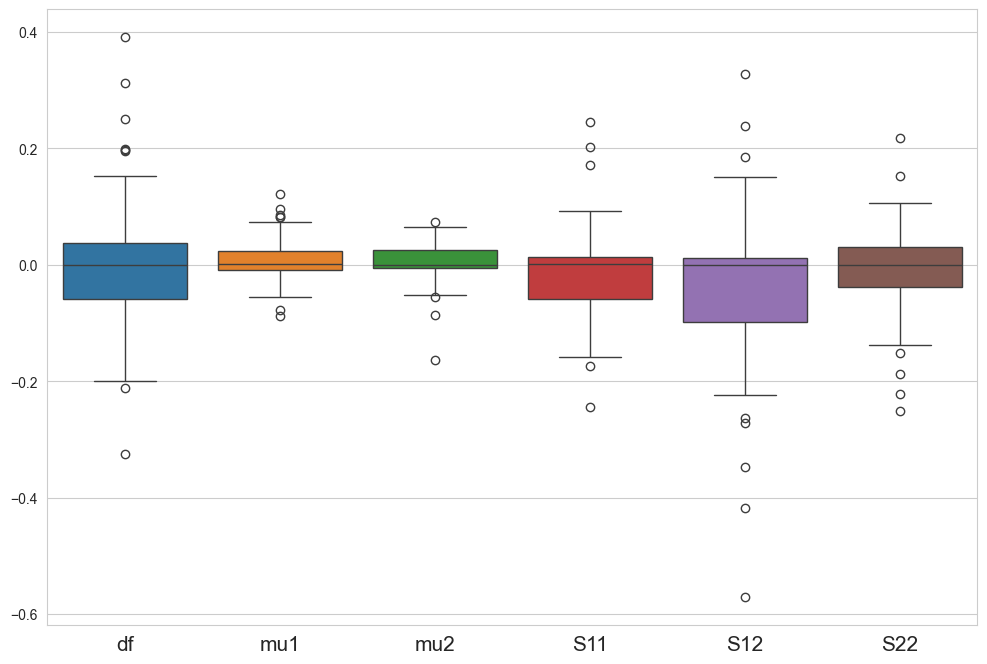

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.boxplot(data=df1)
ax.tick_params(axis='x', labelsize=15)
plt.show()

In [ ]:
# n = int(1e+5)
# df = 6
# mu = np.array([0.0, 10.0])  # locations of X1, X2
# c = np.array([1.0, 2.0])  # scale of X1, X2
# rho = 0.  # correlation
# Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
#                   [rho*c[0]*c[1], c[1]**2]])
# simdata = multivariate_t.rvs(loc=mu, shape=Sigma, df=df, size=n)
# a1 = 1
# a2 = 1 - a1
# X1 = simdata[:,0]
# X2 = simdata[:,1]
# P = a1*X1 + a2*X2
# phist = sns.histplot(P, kde=True, stat="density", bins=50)
# phist.set_xlabel("P")
# phist.plot(xv, P_val, 'r-')
# # phist.plot(xv, stt.pdf(xv, df=df), 'k-')

In [128]:
def sum_mvt_cf(t, muvec, avec, Sigma, v):
    # Characteristic function of P = a1X1 + a2X2, where 
    # (X1, X2) ~ t(mu, Sigma, v) are bivariate location-scale
    # t random vectors
    
    if v < 0:
        raise ValueError("Degree of freedom should be postive.")
    if isinstance(df, float) and (not df.isinteger()):
        raise ValueError("Degree of freedom should be an integer.")
    
    muvec = np.array(muvec)
    avec = np.array(avec)
    
    k = np.sqrt(np.dot(avec, np.matmul(Sigma, avec)))  # k = sqrt(aT * Sigma * a) 
    z = v**0.5 * np.abs(t) * k
    K = kv(v/2, z) # Problem: generated some inf values
    G = gamma(v/2)
    mus = np.dot(avec, muvec)
    return np.exp(1.j * t * mus) * K * z**(v/2) / (G * 2**((v/2)-1))


def sum_mvt_IFFT(muvec, avec, Sigma, v, ell=-6, dx=0.001, T=2**16):
    # Inverser fast Fourier transsformation for student t
    # lowlim is the lower limit in finite integral approximation to the c.f.
    # use a smaller value of lowlim for low dof
    
    if df < 0:
        raise ValueError("Degree of freedom should be postive.")
    if isinstance(df, float) and (not df.isinteger()):
        raise ValueError("Degree of freedom should be an integer.")
    
    t = np.arange(-T/2, T/2)
    if np.any(t==0):
        t[np.where(t==0)] = 1e-8
    s = 2*np.pi*t/(T*dx)
    phi = sum_mvt_cf(s, muvec, avec, Sigma, v)
    g = phi * np.exp(-1.j*s*ell)
    P = ifft(g)
    pdf = P/dx
    x = np.arange(dx, (T+1)*dx, dx) + ell
    if max(np.imag(abs(pdf))) > 1e+8:
        raise ValueError("The value of PDF contains imaginary numbers.")
        
    return np.flip(abs(pdf)), x

In [145]:
v = 6
muvec = np.array([0.0, 10.0])  # locations of X1, X2
c = np.array([1.0, 2.0])  # scale of X1, X2
rho = 0.6  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
                  [rho*c[0]*c[1], c[1]**2]])
a1 = 0.2
avec = np.array([a1, 1-a1])

P_inv, x = sum_mvt_IFFT(muvec, avec, Sigma, v, ell=-12)

xv = np.linspace(-12, 30, 10000)
P_val = np.interp(xv, x, P_inv)

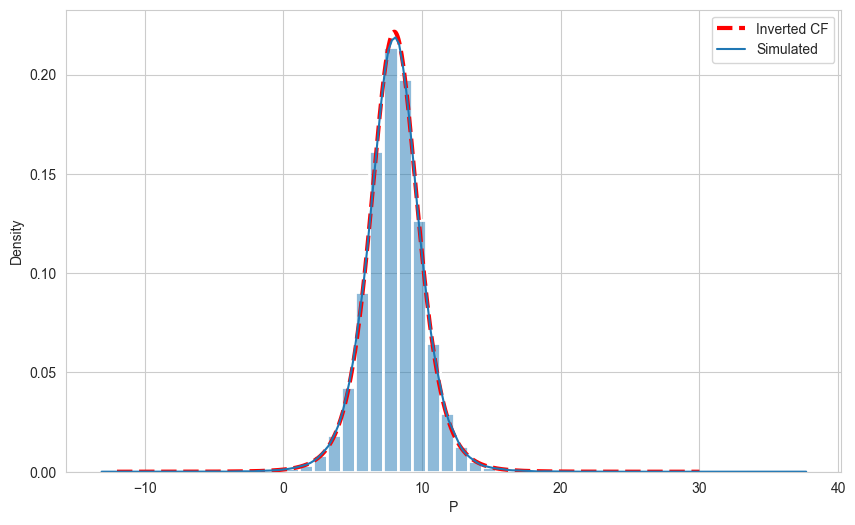

In [150]:
n = int(1e+5)
df = 6
mu = np.array([0.0, 10.0])  # locations of X1, X2
c = np.array([1.0, 2.0])  # scale of X1, X2
rho = 0.6  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
                  [rho*c[0]*c[1], c[1]**2]])
simdata = multivariate_t.rvs(loc=mu, shape=Sigma, df=df, size=n)
a1 = 0.2
a2 = 1 - a1
X1 = simdata[:,0]
X2 = simdata[:,1]
P = a1*X1 + a2*X2
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(xv, P_val, 'r--', linewidth=3)
ax = sns.histplot(P, kde=True, stat="density", bins=50, linewidth=2)
ax.set_xlabel("P")
plt.legend(["Inverted CF", "Simulated"])

In [3]:
df = np.array([1, 3, 6, 9])
mu1 = np.array([1.0])  # locations of X1
mu2 = np.array([2.0])  # locations of X2
temp = np.array(list(it.product(df, mu1, mu2)))

c1 = np.array([0.5, 1.0])  # scale of X1
c2 = np.array([1.5, 2.0])  # scale of X2
rho = np.linspace(0.2, 1.0, 4)  # correlation
S11 = np.repeat(c1**2, c2.shape[0]*rho.shape[0])
S22 = np.tile(np.repeat(c2**2, rho.shape[0]), c1.shape[0])
S12 = np.array([i*j*k for i in c1 for j in c2 for k in rho])
S = np.stack((S11, S12, S22), axis=1)

params_true = np.array([np.hstack((temp[i,:], S[j,:])) 
                        for i in range(temp.shape[0]) 
                        for j in range(S.shape[0])])
params_est = np.zeros(params_true.shape)

In [4]:
params_true.shape

(64, 6)

Part IV: Non-elliptic distributions for modeling financial asset returns.

Motivation:
Asset returns (daily and higher-frequency) are not just non-Gaussian, they are non-elliptic. We need more sophisticated distributions, and also smart laws of motion for the changing scale and correlation terms (simple CCC or DCC GARCH are far from adequate). As always, I love to boast about my research: Just read the abstracts (and note the target journals) to get an idea of where these basic homework ideas can lead:

https://www.sciencedirect.com/science/article/abs/pii/S0304407619301563

https://www.sciencedirect.com/science/article/abs/pii/S0378426621000042

Here, we deal with just the distributional aspect, and stick to an IID structure for simplicity, this being the theme of this first course. We will meet two non-elliptic distributions in this assignment.

Preparation:
Read just the single page of my time series book, page 650. This is for a multivariate Laplace distribution. Notice, crucially, this sentence:

Let (Y ∣ G = g) ∼ N_d (𝝁, g𝚺) for 𝝁 ∈ ℝ^d and 𝚺 > 0, i.e., positive definite, and let G ∼ Gam (b, 1).

So, you see that it is trivial to simulate realizations from Y ∼ Lap(𝝁, 𝚺, b). We will be working only in the d=2 (bivariate) case, so it will be easy for you to make a 2 X 2 positive definite covariance matrix 𝚺.

Next, same book, see page 654, equation (14.41). This is a discrete mixture distribution. We saw this already in Chapter 5 of the Fundamental Statistical Inference book, in the univariate, Gaussian context.

We will only consider a mixture of two components, so k=2.

We saw above that simulating from a single multivariate Laplace is easy. To simulate a discrete mixture of them, this is, in turn, addressed in Fundamental Statistical Inference, the very short section 5.1.2, complete with Matlab codes, in the context of simulating from a discrete mixture of univariate Gaussian. You can trivially adapt them to the model at hand here.

Preparation, continued:
Again, time-series book, please read section 12.2, but just pages 530-532, for the multivariate noncentral Student t distribution (let's call it NCT). We will not need to simulate from it, but it is easy if needed, being a continuous Gaussian mixture distribution like the Laplace.

Notice my approximation to the (log of the) density given there. It is extremely accurate, and insanely fast. It is even more accurate than my saddlepoint approximation to the NCT in the univariate case. So, you need to just copy-paste and use this. Evaluation of the exact density is ridiculously time consuming, and far too slow for actual applications. 

It even turns out that there is, so far at least, no EM algorithm for the (notably multivariate) NCT, which is highly unfortunate. As such, the density approximation I provide is highly useful, and the only way I know to actually use this distribution for modeling large sets of financial asset returns. I told you, lots of tricks!

Assignment:

IV.1. Make a program to input all the relevant parameters for simulating the 2-component, bivariate discrete mixture of Laplace. Document it nicely. Choose reasonable values for parameters, such as might roughly correspond to financial data, e.g., b1=10, b2=5, and the Sigma2 matrix has much larger diagonal elements than Sigma1, this 2nd component of the mixture capturing the more extreme behavior of the returns. Simulate realizations, and produce one nice-looking 3D plot.

IV.2. Recall in question III.1 above, you got a free ride, since the exact codes are right in my book. That was not an accident. Now, you are to make something similar, but for the k=2, d=2 discrete mixture multivariate Laplace.

For d larger, you would need the EM algorithm I derived in my book for this distribution. For our case with k=d=2, there are --- let's count: 4 location terms, Sigma_1 and Sigma_2 have a total of 6 terms, then there is b_1 and b_2, so a total of 12 parameters (you please check this), with obvious constraints on the Sigma elements, and the b_i. So, still very modest for brute force BGFS optimization, and the likelihood is easily obtained from time-series book equations (14.31) and (14.41).

Notice we again need the "modified Bessel function of the third kind", which I give in eq (14.30). To be sure that the function you use (I think besselk in Matlab) is correct, do what I wrote in a recent email: Compute the integral in (14.30), which is definitely what we need, and compare it to the besselk function output. You include the codes for this, and show equivalence.

Make a program to compute the MLE of this distribution (again, just d=k=2).

Choose a large sample size, say T=10,000, and generate *one* data set, and estimate it, and report, in a nice table, the true parameters in one row, and the MLE values in the other. Based on this sample size, the MLE values should be close to the true parameter values. Notice we have what is called a "label switching problem" here, in that mixture components 1 and 2 could be switched (and also of course the two weights in the mixture), and the model does not change. Be sure to keep that in mind when reporting your results.

Using my generic MLE codes from Chapter 4 with BFGS, you can also produce approximate standard errors for the parameters. Report these also. You do *not* need to generate more accurate confidence intervals via a bootstrap. There are two reasons I do not request this:

a) you have enough to do already in this assignment,

b) *who cares* about them, or arguably even the (freely obtained) "standard errors" from BFGS? The point of the model is to fit real data, and do portfolio optimization. The only relevant model assessment is OOS performance of portfolio allocation (or, risk assessment perhaps). The actual parameters of the model are, for us, essentially "nuisances that need to be calibrated".

IV.3. Make a program to compute the MLE of the bivariate (so, dimension 2) NCT. Recall the "preparation" notes above. It inputs obviously a T X 2 data set, and outputs the MLE parameter vector.

Now make a program that inputs a T X 2 data set, and computes and outputs the MLE of the bivariate 2-component mixture Laplace, and that of the bivariate NCT. This is obviously trivial --- it just combines your previous two programs. What is new is this: You also output the AIC and BIC values corresponding to to each of the two models, so that we can, via these in-sample model-comparison methods, ascertain which model is preferred by the data.

IV.4. I attach a data set (a matrix) of (percentage log) daily returns from the stocks on the DJIA, with d=25 stocks. There is an excel version, and a Matlab version, the former if some of you wish to use, say, Python. (See note below about Python.)

As you all know, the DIJA index has 30 stocks. I have a data set from Jan-1990 to Oct-2021 (yielding about 8000 time points). At that starting date, only 25 stocks have valid data, and hence I only send the returns for those 25 stocks. That is fine for our purpose here. (This data set is also not corrected for survivorship bias. Ask me in class if you are curious what that it is, and/or web-search it. We do not care about this bias for our purpose in this assignment.)

For this exercise, we do not need time-stamps, or names of stocks. The reason is that we are in pure statistics learning mode here. In reality, you would need that further stock level info (and account for survivorship bias in the index), and also, as I belabored above, augment in-sample measures (AIC and BIC, etc.) with out-of-sample performance measures, e.g., several of the various risk-return measures such as Sharpe, max-drawdown, Sortino, Rachev ratio, etc., along with accounting for transaction costs, doing various robustness checks, etc..

Set up a (nicely documented) program that inputs this data set, and then:

--------------------------------------

For rep = 1:50   % You can of course use more than 50! Please try if feasible.
                          % And, you do not need to worry if you draw the same pair.
                          % With unlimited computing resources, you would choose,
                          % say, 1000 pairs.

   randomly draw 2 out of the 25 stocks.

   fit the Mix-Lap and the NCT; store their AIC and BIC values
 
end

Output of the function:

1. The 50 X 4 table of AIC and BIC values, for each of the two distributional models.

2. A *smart plot* (everything should be totally clear by just looking at it) comparing the AIC values. And then, similar, for BIC.

--------------------------------------

Write in your report the conclusions, e.g., "According to AIC (BIC), the mix-lap is preferred in 80% (74%) of the cases." Be sure to discuss in your report your algorithm for randomly choosing 2 stocks. Trivial for you data-science majors, and actually all of you, but it is even little things like this that "non quant finance people" have no clue how to do. But they do know the CAPM model, have passed the first CFA exam, and know that a matrix is not just a movie.

IV.5. Stop, you are done.

In [19]:
def simMix2Lap2(mumat, Sigma, bvec, lmda, n=1000):
    '''
    This function generates n 2-dim random vectors from 2-component mixture of bivariate Laplace distribution, denoted as Mix2Lap2 
    :param mumat: location of the components, matrix of shape (2, 2)
    :param Sigma: scale matrix of the components, ndarray of shape (2,2,2)
    :param bvec: scale of Laplace of the componennts, array of length 2
    :param lmda: weight of the mixture, scalar in between [0, 1]
    :param n: size of realization, int
    :return: n x 2 numpy.ndarray
    '''
    eigvals = np.linalg.eig(Sigma)[0]
    if np.min(eigvals) < 1e-10:
        raise ValueError("The scale matrices have to be positive definite.")
    Y = np.zeros((n,2))
    for i in range(n):
        ind = choice(2, p=[lmda, 1-lmda])
        g = stats.gamma.rvs(bvec[ind])
        Y[i] = multivariate_normal.rvs(mumat[:, ind], g*Sigma[ind])
    return Y
    

In [20]:
seed(8052)
n = int(1e+3)
lmda = 0.2
mu1 = np.array([50.0, 100.0])  # locations of N1
c1 = np.array([1.0, 2.0])  # scale of N1
rho1 = 0.8  # correlation
S1 = np.array([[c1[0]**2, rho1*c1[0]*c1[1]],
                  [rho1*c1[0]*c1[1], c1[1]**2]])

mu2 = np.array([0.0, 0.0])  # locations of N2
c2 = np.array([5.0, 8.0])  # scale of N2
rho2 = 0.2  # correlation
S2 = np.array([[c2[0]**2, rho2*c2[0]*c2[1]],
                  [rho2*c2[0]*c2[1], c2[1]**2]])

mumat = np.stack([mu1, mu2], axis=1)
Sigma = np.array([S1, S2])
bvec = np.array([10, 5])
Y = simMix2Lap2(mumat, Sigma, bvec, lmda, n)
Y.shape

(1000, 2)

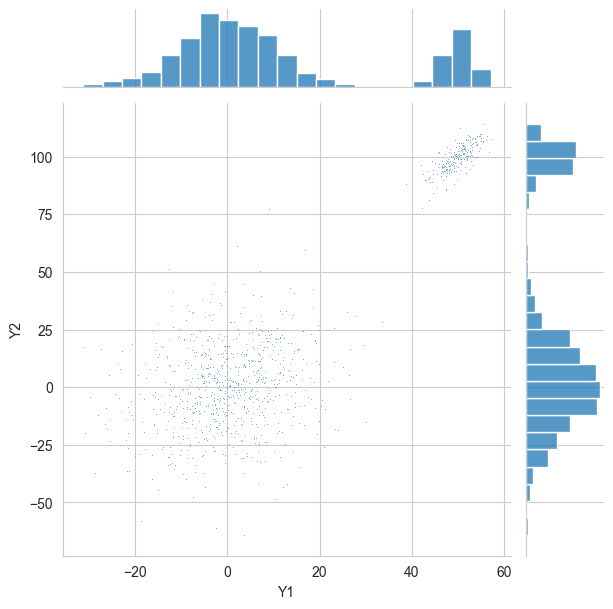

In [21]:
fig = sns.jointplot(x=Y[:,0], y=Y[:,1], s=.5)
fig.set_axis_labels("Y1", "Y2")
plt.show()

In [30]:
# MLE of params and std. errors for 10,000 realization of multivariate Mix2Lap2 random vectors
initguess = np.array([45, 95, 0.05, 0.05, 1.1, 1.5, 3.5, 25.1, 8.2, 64.2, 9.8, 5.2])
params, stderr = np.array(eng.MixLapEstimate(Y, initguess, lmda, nargout=2))

In [31]:
params.T

array([[ 4.98514171e+01,  9.97145413e+01, -1.15755255e-01,
         1.46231931e-02,  2.23584620e+00,  3.22484903e+00,
         7.77036705e+00,  1.63635836e+01,  6.63690407e+00,
         5.04270302e+01,  4.59756856e+00,  6.65494428e+00]])

In [32]:
stderr.T

array([[ 0.21550384,  0.40313939,  0.36645211,  0.64315755,  0.69660065,
         1.04213   ,  2.4279069 ,  6.38304918,  2.84967619, 19.67598601,
         1.34941707,  2.51669318]])

In [6]:
def validateBesselK(xvec, nuvec):
    '''
    This function is to confirm "modified Bessel function of the third kind" is implemented as BesselK in MatLab, and kv in scipy.specials
    :param xvec: x at which the integral be evaluated, 1d array
    :param nuvec: nu, 1d array
    :return: logical
    '''
    nx, nv = len(xvec), len(nuvec)
    K_intg = np.zeros((nv, nx))
    K_kv = np.zeros((nv, nx))
    K_bslk = np.zeros((nv, nx))
    diff_kv = np.zeros((nuvec.shape[0]))
    diff_bslk = np.zeros((nuvec.shape[0]))
    for i in range(nv):
        v = nu[i]
        f = lambda u: 0.5 * u**(v-1) * np.exp((1/u + u) * (-xvec) /2)
        K_intg[i,:] = quad_vec(f, 0, np.inf)[0]
        K_kv[i,:] = kv(v, xvec)
        K_bslk[i,:] = np.array(eng.besselk(v, xvec))
        diff_kv[i] = np.max(np.abs(K_intg - K_kv))
        diff_bslk[i] = np.max(np.abs(K_intg - K_bslk))
    
    return diff_kv, diff_bslk

In [7]:
nu = np.array([1., 2., 3., 5.])
x = np.linspace(1., 5., 200)
d_kv, d_bslk = validateBesselK(x, nu)

In [9]:
d_bslk

array([3.33066907e-16, 9.10382880e-15, 4.41424675e-13, 4.41424675e-13])

In [100]:
datfrm = pd.read_csv("DJIA30stockreturns.csv", sep=',', header=None)
dat = datfrm.values
print(np.any(np.isnan(dat)))
print(np.any(np.isinf(dat)))

False
False


In [12]:
def simMVNCT(muvec, gam, v, Sigma, n=1000):
    '''
    This function generates n 2-dim random vectors of bivariate noncentral location-scale t distribution.
    :param muvec: location, 
    :param gam: noncentrality
    :param Sigma: scale matrix
    :param v: degrees of freedom
    :param n: int
    :return: n x 2 numpy.ndarray
    '''
    eigvals = np.linalg.eig(Sigma)[0]
    if np.min(eigvals) < 1e-10:
        raise ValueError("The scale matrices have to be positive definite.")
    Y = np.zeros((n,2))
    for i in range(n):
        g = stats.gamma.rvs(v/2, scale=2/v)
        if abs(g) < 1e-6:
            g = 1e-6;
        g = 1/g;
        Y[i] = multivariate_normal.rvs(mean=muvec+g*gam, cov=g*Sigma)
    return Y

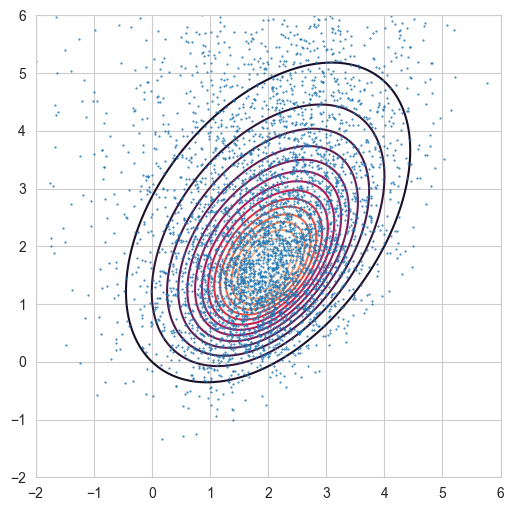

In [166]:
df = 5.0
n = int(5e+3)
mu = np.array([2.0, 0.0])  # locations of X1, X2
gam = np.array([0, 2.0])
c = [1.0, 1.0]  # scale of X1, X2
rho = 0.5  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
         [rho*c[0]*c[1], c[1]**2]])
sim_binct = simMVNCT(mu, gam, df, Sigma, n)
fig, ax = plt.subplots(1,1, figsize=(6,6))
xv = np.arange(-10.0, 10.0, 0.01)
yv = np.arange(-10.0, 10.0, 0.01)
xg, yg = np.meshgrid(xv, yv)
x = xg.flatten()
y = yg.flatten()
X = np.vstack((x, y))
pdf = np.array(eng.mvnctpdfln(X, mu, gam, df, Sigma))
pdf = np.exp(pdf).T
z = pdf.reshape((len(yv), len(xv)))
ax.contour(xg, yg, z, levels=15)
ax.plot(sim_binct[:,0], sim_binct[:,1], 'o', ms=.5)
ax.set(xlim=(-2,6), ylim=(-2,6))
# ax.set_aspect("equal")
plt.show()

In [13]:
#np.random.seed(8052)
df = 3.0
n = int(5e+4)
mu = np.array([3.0, 1.0])  # locations of X1, X2
gam = np.array([1.0, 3.0])
c = [1.0, 1.0]  # scale of X1, X2
rho = 0.5  # correlation
Sigma = np.array([[c[0]**2, rho*c[0]*c[1]],
         [rho*c[0]*c[1], c[1]**2]])
Y = simMVNCT(mu, gam, df, Sigma, n)

# mu1, mu2, gam1, gam2, v, S11, S12, S22
initguess1 = np.array([2.0, 0.5, .5, 2.5, 2.5, 1.5, 0.4, 2])
params1, stderr1 = np.array(eng.MVNCTestimate(Y, initguess1, nargout=2))

# k mu1 mu2 scale1 scale2 R12 gam1 gam2
initguess2 = np.array([4., 2., .5, 1., 1., 0.4, .5, 2.5])
params2, stderr2 = np.array(eng.MVNCT2estimation(Y, initguess2, nargout=2))


In [14]:
# mu1, mu2, gam1, gam2, v, S11, S12, S22
params1.T

array([[2.67850629, 0.0282472 , 1.32936472, 3.99999824, 1.69891167,
        0.79072025, 0.69942012, 1.77943397]])

In [15]:
stderr1.T

array([[1.13438429e-02, 9.70788196e-03, 8.99191054e-03, 7.60173394e-05,
        4.22168321e-03, 6.64906342e-03, 8.32521532e-03, 1.95992628e-02]])

In [16]:
# k mu1 mu2 scale1 scale2 R12 gam1 gam2
params2.T

array([[ 1.92468901,  2.42483357, -0.77353261,  0.94562053,  1.23681926,
         0.56602849,  1.74071573,  3.99741979]])

In [17]:
stderr2.T

array([[0.00775255, 0.02424165, 0.01937736, 0.00512042, 0.00489344,
        0.00506604, 0.03185266, 0.00404051]])

In [23]:
np.any(np.iscomplex(params2))

False

In [20]:
stderr.T

array([[0.01436211, 0.01860819, 0.01004676, 0.00476544, 0.171538  ,
        0.01004131, 0.01656058, 0.02093679]])

In [118]:
def models_AIC_BIC(data, rep):
    '''
    :param data: 
    :param rep: 
    :return: 
    '''
    N = data.shape[0]
    nstock = data.shape[1]
    k1, k2 = 12, 8  # number of estimated params for Mix2Lap2 and Bi-NCT respectively
    AIC = np.zeros((rep, 2))
    BIC = np.zeros((rep, 2))
    X = np.zeros((N, 2))
    for i in range(rep):
        j1, j2 = choice(nstock, 2, replace=False)
        X[:,0] = data[:,j1]
        X[:,1] = data[:,j2]
        ll_mixlap = eng.MixLapEstimate(X, nargout=4)[-1]
        ll_bNCT = eng.MVNCT2estimation(X, nargout=4)[-1]
        AIC[i,0] = 2*(k1 - ll_mixlap)
        AIC[i,1] = 2*(k2 - ll_bNCT)
        BIC[i,0] = k2*log(N) - 2*ll_mixlap
        BIC[i,1] = k2*log(N) - 2*ll_bNCT
    result = pd.DataFrame(np.stack([AIC, BIC]), axis=1, 
                          columns=["AIC_mxlap", "AIC_bNCT","BIC_mxlap", "BIC_bNCT" ])
    
    
        

In [121]:
result = models_AIC_BIC(dat[:100,:], 1)


MatlabExecutionError: 
  File C:\Users\pansc\PycharmProjects\sff2\MVNCT2estimation.m, line 46, in mvnctpdfln

  File C:\Users\pansc\PycharmProjects\sff2\MVNCT2estimation.m, line 25, in MVNCTloglik

  File C:\Users\pansc\PycharmProjects\sff2\MVNCT2estimation.m, line 12, in @(param)MVNCTloglik(param,x,bound)

  File C:\Program Files\MATLAB\R2023b\toolbox\shared\optimlib\fminunc.m, line 336, in fminunc

  File C:\Users\pansc\PycharmProjects\sff2\MVNCT2estimation.m, line 12, in MVNCT2estimation
Not enough input arguments.
